In [0]:
# Google ドライブをマウントするには、このセルを実行してください。
from google.colab import drive
drive.mount('drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at drive


In [0]:
path = "/content/drive/My Drive/My Documents/DIVE_INTO_CODE/グループワーク：セルフレジ/"
ayataka_path = '/content/drive/My Drive/My Documents/DIVE_INTO_CODE/グループワーク：セルフレジ/pics/train/ayataka'
ilohas_path = '/content/drive/My Drive/My Documents/DIVE_INTO_CODE/グループワーク：セルフレジ/pics/train/ilohas'
cocacola_path =  '/content/drive/My Drive/My Documents/DIVE_INTO_CODE/グループワーク：セルフレジ/pics/train/cocacola'

In [0]:
copy_path = '/content/drive/My Drive/My Documents/DIVE_INTO_CODE/グループワーク：セルフレジ/pics/models/ilohas/train/01_ilohas'

In [0]:
os.chdir(path)

In [0]:
!pip install livelossplot

### Fitting

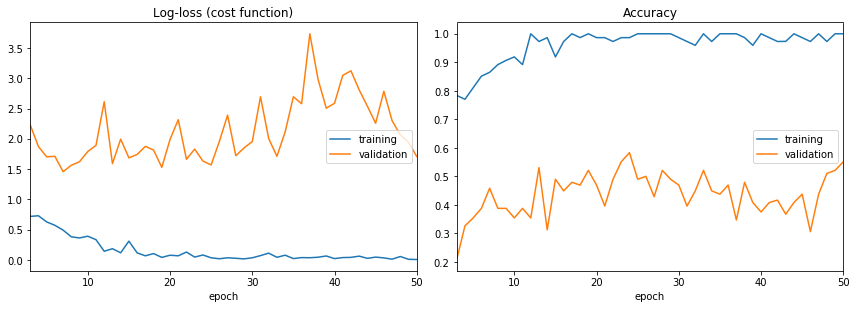

Log-loss (cost function):
training   (min:    0.005, max:    1.475, cur:    0.005)
validation (min:    1.456, max:    3.735, cur:    1.707)

Accuracy:
training   (min:    0.568, max:    1.000, cur:    1.000)
validation (min:    0.204, max:    0.583, cur:    0.551)

Epoch 00050: val_loss did not improve from 1.45639


In [0]:
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D,Input,Dropout
from keras.applications.mobilenet import MobileNet
from keras.applications.mobilenetv2 import MobileNetV2
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import CSVLogger,EarlyStopping
from livelossplot.keras import PlotLossesCallback
from keras.callbacks import ModelCheckpoint

%matplotlib inline

n_categories=7
batch_size=5

train_dir = 'pics/models/ilohas/train'
validation_dir = 'pics/models/ilohas/val'
file_name='MobileNetV2_shape224_scraping_ilohas_12.5%'

base_model=MobileNetV2(input_shape=(224,224,3),
                       weights='imagenet',
                       include_top=False)

#add new layers instead of FC networks
x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dropout(0.5)(x)
x=Dense(1024, activation='relu')(x)
prediction=Dense(n_categories,activation='softmax')(x)
model=Model(inputs=base_model.input,outputs=prediction)

#fix weights before MobileNet
for layer in base_model.layers[:85]:
      layer.trainable=False

model.compile(optimizer=Adam(lr=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#model.summary()

#model_checkpoint
model_checkpoint = ModelCheckpoint(
    filepath=file_name+'.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    period=1
)

#save model
train_datagen = ImageDataGenerator(
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      rescale=1.0/255,
      shear_range=0.2,
      zoom_range=0.2,
      vertical_flip=False,
      horizontal_flip=False
)

validation_datagen=ImageDataGenerator(rescale=1.0/255)

train_generator=train_datagen.flow_from_directory(
      train_dir,
      target_size=(224,224),
      batch_size=batch_size,
      class_mode='categorical',
      shuffle=True
)

validation_generator=validation_datagen.flow_from_directory(
      validation_dir,
      target_size=(224,224),
      batch_size=batch_size,
      class_mode='categorical',
      shuffle=True
)

hist=model.fit_generator(train_generator,
                         steps_per_epoch=15,
                         epochs=50,
                         verbose=1,
                         validation_data=validation_generator,
                         validation_steps=10,
                         #callbacks=[EarlyStopping(patience=2),PlotLossesCallback()]
                         callbacks=[PlotLossesCallback(), model_checkpoint]
                         
                         
                        )

### Test

In [0]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

test_dir = 'pics/models/ilohas/val'


print(os.listdir(test_dir))

n_test_samples=32

test_datagen=ImageDataGenerator(rescale=1.0/255)

test_generator=test_datagen.flow_from_directory(
      test_dir,
      target_size=(224,224),
      shuffle=False
)

model.load_weights('MobileNetV2_shape224_scraping_ilohas_12.5%.h5')

proba = model.predict_generator(test_generator, steps=n_test_samples)

print(proba)

#print(np.max(preds, axis=1))

preds = np.argmax(proba, axis=1)

#print(preds)
#print(preds.shape)

for idx, _ in enumerate(test_generator):
  print("filename : ", test_generator.filenames[idx])
  img = Image.open("./pics/models/ilohas/val/" + test_generator.filenames[idx])
  img = np.array(img)
  plt.imshow(img)
  plt.title(str(preds[idx]) + " : " + str(np.max(proba[idx])))
  plt.show()

Output hidden; open in https://colab.research.google.com to view.